In [21]:
%load_ext autoreload
%autoreload 2
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset
from hmpai.data import SAT1_STAGES_ACCURACY
from hmpai.visualization import plot_confusion_matrix
from hmpai.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
# from braindecode.models.eegconformer import EEGConformer
from mne.io import read_info

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load datasets

In [35]:
set_global_seed(42)
# data_path = Path("../data/sat1/split_stage_data_100hz.nc")
data_path = Path("../data/sat2/split_stage_data_100hz_10samples.nc")
# data_path = Path("../data/sat1/split_stage_data_100hz.nc")
# data_path = Path("../data/ar/split_stage_data.nc")
# data_path = Path("../data/sat1/split_stage_data_unprocessed_500hz.nc")

dataset = xr.load_dataset(data_path)

In [5]:
ar_data_path = Path("../data/ar/split_stage_data.nc")
ar_dataset = xr.load_dataset(ar_data_path)

In [72]:
# channels = list(dataset.channels.to_numpy())
# channels_upper = [ch.upper() for ch in channels]
# dataset["channels"] = channels_upper
# dataset = dataset.reindex({"channels": AR_SAT1_CHANNELS})

In [36]:
shape_topological = False
train_data, val_data, test_data = split_data_on_participants(
    dataset, 60, norm_min1_to_1
)
train_dataset = SAT1Dataset(train_data, shape_topological=shape_topological)
val_dataset = SAT1Dataset(val_data, shape_topological=shape_topological)
test_dataset = SAT1Dataset(test_data, shape_topological=shape_topological)

#### Transformer (single run)

In [45]:
# TODO: Look into tensor device mismatch
model = TransformerModel(
    len(train_data.channels),
    10,
    512,
    6,
    len(train_data.samples),
    len(train_data.labels),
)

train_and_test(
    model,
    train_dataset,
    test_dataset,
    val_dataset,
    logs_path=Path("../logs/"),
    workers=4,
    batch_size=128,
    labels=SAT1_STAGES_ACCURACY,
    weight_decay=0.001,
    label_smoothing=0.0001,
    do_spectral_decoupling=False,
)

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  0%|          | 0/681 [00:00<?, ? batch/s]

  0%|          | 0/681 [00:00<?, ? batch/s]

  0%|          | 0/681 [00:00<?, ? batch/s]

  0%|          | 0/681 [00:00<?, ? batch/s]

  0%|          | 0/681 [00:00<?, ? batch/s]

  0%|          | 0/681 [00:00<?, ? batch/s]

  0%|          | 0/681 [00:00<?, ? batch/s]

  0%|          | 0/681 [00:00<?, ? batch/s]

  0%|          | 0/681 [00:00<?, ? batch/s]

  0%|          | 0/681 [00:00<?, ? batch/s]

  0%|          | 0/681 [00:00<?, ? batch/s]

{'0': {'precision': 0.9808176981237748,
  'recall': 0.9097402597402597,
  'f1-score': 0.943942864843013,
  'support': 7700.0},
 '1': {'precision': 0.7874410825604379,
  'recall': 0.6144992880873279,
  'f1-score': 0.6903032322559146,
  'support': 8428.0},
 '2': {'precision': 0.8666508200618017,
  'recall': 0.8652112007593735,
  'f1-score': 0.8659304120650754,
  'support': 8428.0},
 '3': {'precision': 0.6012301383905689,
  'recall': 0.8654697491392032,
  'f1-score': 0.7095473334005444,
  'support': 4066.0},
 '4': {'precision': 0.8309796999117387,
  'recall': 0.893687707641196,
  'f1-score': 0.8611936885433341,
  'support': 8428.0},
 'accuracy': 0.823940620782726,
 'macro avg': {'precision': 0.8134238878096645,
  'recall': 0.8297216410734721,
  'f1-score': 0.8141835062215763,
  'support': 37050.0},
 'weighted avg': {'precision': 0.8351169091607419,
  'recall': 0.823940620782726,
  'f1-score': 0.8239529575783626,
  'support': 37050.0}}

#### LSTM (Single run)

In [4]:
model = SAT1GRU(
    len(train_data.channels), len(train_data.samples), len(train_data.labels)
)

train_and_test(
    model,
    train_dataset,
    test_dataset,
    val_dataset,
    logs_path=Path("../logs/"),
    workers=4,
    batch_size=128,
    labels=SAT1_STAGES_ACCURACY,
)

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/97 [00:00<?, ? batch/s]

  0%|          | 0/97 [00:00<?, ? batch/s]

  0%|          | 0/97 [00:00<?, ? batch/s]

  0%|          | 0/97 [00:00<?, ? batch/s]

  0%|          | 0/97 [00:00<?, ? batch/s]

  0%|          | 0/97 [00:00<?, ? batch/s]

  0%|          | 0/97 [00:00<?, ? batch/s]

  0%|          | 0/97 [00:00<?, ? batch/s]

  0%|          | 0/97 [00:00<?, ? batch/s]

  0%|          | 0/97 [00:00<?, ? batch/s]

  0%|          | 0/97 [00:00<?, ? batch/s]

  0%|          | 0/97 [00:00<?, ? batch/s]

  0%|          | 0/97 [00:00<?, ? batch/s]

  0%|          | 0/97 [00:00<?, ? batch/s]

{'0': {'precision': 0.7616892911010558,
  'recall': 0.5791284403669725,
  'f1-score': 0.6579804560260587,
  'support': 872.0},
 '1': {'precision': 0.7706323687031083,
  'recall': 0.8198403648802737,
  'f1-score': 0.7944751381215469,
  'support': 877.0},
 '2': {'precision': 0.8766157461809636,
  'recall': 0.8506271379703535,
  'f1-score': 0.863425925925926,
  'support': 877.0},
 '3': {'precision': 0.7745454545454545,
  'recall': 0.9362637362637363,
  'f1-score': 0.8477611940298506,
  'support': 455.0},
 '4': {'precision': 0.8491155046826223,
  'recall': 0.9304446978335233,
  'f1-score': 0.8879216539717084,
  'support': 877.0},
 'accuracy': 0.8115209701869631,
 'macro avg': {'precision': 0.8065196730426409,
  'recall': 0.8232608754629718,
  'f1-score': 0.8103128736150182,
  'support': 3958.0},
 'weighted avg': {'precision': 0.8099853810051272,
  'recall': 0.8115209701869631,
  'f1-score': 0.8065125883378291,
  'support': 3958.0}}

#### GRU (Single run, with manual test/train selection)

In [ ]:
model = SAT1GRU(len(dataset.channels), len(dataset.samples), len(dataset.labels))
test_dataset = SAT1Dataset(dataset.sel(participant=["0014"]))
train_dataset = SAT1Dataset(
    dataset.sel(participant=[p for p in dataset.participant.values if p != "0014"])
)
train_and_test(
    model,
    train_dataset,
    test_dataset,
    test_dataset,
    logs_path=Path("../logs/"),
    workers=0,
    batch_size=128,
)

#### CNN (Deep, for 500Hz data, single run)

In [ ]:
model = SAT1Deep(
    len(train_data.channels), len(train_data.samples), len(train_data.labels)
)

train_and_test(
    model,
    train_dataset,
    test_dataset,
    val_dataset,
    logs_path=Path("../logs/"),
    workers=4,
)

#### CNN (Deep, for topological 500Hz data, single run)

In [ ]:
height, width = CHANNELS_2D.shape
model = SAT1TopologicalConv(
    width, height, len(train_data.samples), len(train_data.labels)
)
train_and_test(
    model,
    train_dataset,
    test_dataset,
    val_dataset,
    logs_path=Path("../logs/"),
    workers=4,
)

#### CNN K-Fold CV (Deep)

In [ ]:
train_kwargs = {"logs_path": Path("../logs/")}
model_kwargs = {
    "n_channels": len(dataset.channels),
    "n_samples": len(dataset.samples),
    "n_classes": len(dataset.labels),
}
results = k_fold_cross_validate(
    SAT1Deep,
    model_kwargs,
    dataset,
    k=25,
    batch_size=128,
    normalization_fn=norm_dummy,
    train_kwargs={
        "logs_path": Path("../logs/CNN_performance"),
        "additional_name": "CNN_DEEP",
    },
)
print_results(results)

#### GRU K-Fold CV

In [ ]:
train_kwargs = {"logs_path": Path("../logs/")}
model_kwargs = {
    "n_channels": len(dataset.channels),
    "n_samples": len(dataset.samples),
    "n_classes": len(dataset.labels),
}
results = k_fold_cross_validate(
    SAT1GRU,
    model_kwargs,
    dataset,
    k=25,
    batch_size=128,
    normalization_fn=norm_min1_to_1,
    train_kwargs={
        "logs_path": Path("../logs/GRU_performance"),
        "additional_name": "GRU",
    },
)
print_results(results)

### Examine results using confusion matrix

In [4]:
chk_path = Path("../models/cnn100/checkpoint.pt")
checkpoint = load_model(chk_path)

model_kwargs = {
    "n_channels": len(dataset.channels),
    "n_samples": len(dataset.samples),
    "n_classes": len(dataset.labels),
}
model = SAT1Base(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [48]:
# data_path_sat1 = Path("../data/sat2/split_stage_data_100hz_10samples.nc")
data_path_sat1 = Path("../data/sat1/split_stage_data_100hz.nc")
dataset_sat1 = xr.load_dataset(data_path_sat1)

shape_topological = False
train_data_sat1, val_data_sat1, test_data_sat1 = split_data_on_participants(
    dataset_sat1, 60, norm_min1_to_1
)
train_dataset_sat1 = SAT1Dataset(train_data_sat1, shape_topological=shape_topological)
val_dataset_sat1 = SAT1Dataset(val_data_sat1, shape_topological=shape_topological)
test_dataset_sat1 = SAT1Dataset(test_data_sat1, shape_topological=shape_topological)

test_loader = DataLoader(
    test_dataset_sat1, 128, shuffle=True, num_workers=4, pin_memory=True
)
results, pred, true = test(model, test_loader, None)
pred = pred.cpu()

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [46]:
test_loader = DataLoader(
    test_dataset, 128, shuffle=True, num_workers=4, pin_memory=True
)
results, pred, true = test(model, test_loader, None)
pred = pred.cpu()

0.3390601313794846


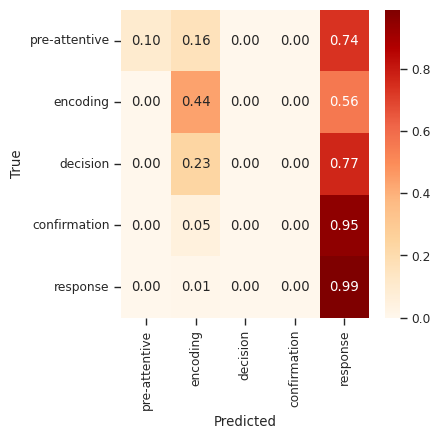

In [49]:
plot_confusion_matrix(true, pred, SAT1_STAGES_ACCURACY)